# **Práctica Clustering**


## **Clustering**

*Clustering
El un método de *machine learning*, **no supervisados**, cuyo principal objetivo encontrar grupos de datos con patrones similares. Algunos de esos  
algoritmos son [**kmeans**](https://towardsdatascience.com/k-means-clustering-algorithm-applications-evaluation-methods-and-drawbacks-aa03e644b48a), [**mean sheaf**](https://www.geeksforgeeks.org/ml-mean-shift-clustering/) y [**DBScan**](https://www.kdnuggets.com/2020/04/dbscan-clustering-algorithm-machine-learning.html)  


## **Segmentación de imágenes médicas mediante técnicas de clustering**


Para esta práctica vuestro grupo utilizará la siguiente 
[base de datos](https://drive.google.com/file/d/1HuOf5CWxZRsWr-37TIxP5msAqmgsYE4o/view?usp=sharing). Esta base de datos contiene imágenes BMP de tomografías de cerebro.

Tenga en cuanta que as imágenes, a color, son cubos de m x n x k , donde m es el número de filas, n el número de columnas y K=3, en caso de imágenes a color, es el número de canales de la imagen.  Por otro lado, cada pixel, se representa, generalmente como un vector de tamaño k, donde k es el número canales. Luego, podemos pensar en una imagen como un conjunto de puntos en un espacio k  dimensional y por lo tanto, podemos agrupar aquellos pixels cuyos vectores sean lo más similares entre sí, esto aplicando cualquiera de los métodos vistos en clase. 


## **Actividades**

1. Utilizar el algoritmo kmeans, DBscan y meanshift para generar cluster con las imágenes de cerebros.


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from scipy.spatial import distance
from operator import itemgetter
import time
import imageio
import os
from natsort import natsorted

In [19]:
# IMG_PATH = 'data/'
IMG_PATH ='mini_data/'

In [20]:
def get_data(src_dir):
    """
    get_data

    :param src_dir: Directorio origen para leer las imágenes.
    :return np.asarray(x): Vector con los vectores característicos de las imágenes en 1D.
    """
    data = []

    for train_img in natsorted(os.listdir(src_dir)):
        image_path = f"{src_dir}/{train_img}"
        img = Image.open(image_path)
        newsize = (100, 100)
        img = img.resize(newsize)
        matrix = np.asarray(img)
        matrix = [list(matrix[i][j]) + [i, j] for i in range(len(matrix)) for j in range(len(matrix[i]))]
        matrix = pd.DataFrame(matrix, columns=['R','G','B','i','j'])
        data.append(matrix)
    return data

In [21]:
data = get_data(IMG_PATH)

In [22]:
# https://www.geeksforgeeks.org/calculate-the-euclidean-distance-using-numpy/
def euclidean(x1, x2):
    return distance.euclidean(x1, x2)

def chebychev(x1, x2):
    return distance.chebyshev(x1, x2)

def manhattan(x1, x2):
    return distance.cityblock(x1, x2)

In [23]:
# https://neptune.ai/blog/k-means-clustering
def rand_centroids(data, k, distance):
    r, c = data.shape
    c_idx = np.random.choice(r, k)
    return data.iloc[c_idx].to_numpy()

def plus_plus(data, k, distance):
    centroids = [ data.sample(n=1).to_numpy().tolist()[0] ]
    for _ in range(k-1):
        new_c = ([],-1)         # centroid, distance to c
        for i in range(len(data)):
            x_i = data.iloc[i].to_numpy().tolist()
            if x_i not in centroids:
                d = 0
                for c in centroids:
                    d += pow(distance(c, x_i), 2)
                d /= len(centroids)
                new_c = (x_i, d) if new_c[1] < d else new_c
        centroids.append(new_c[0])
    return np.matrix(centroids)    

In [24]:
class K_Means():
    def __init__(self, n, distance=euclidean, cc=rand_centroids):
        self.data = None
        self.n = n          # n° centroids
        self.K = None
        self.d = distance
        self.cc = cc        # centroid criteria

    def new_centroids(self, idx):
        new_K = [[] for _ in self.K]

        for i in range(len(self.K)):
            # obtener indices de todos los elementos pertenecientes al cluster i de la lista de indeices
            idx_curr_cluster = idx[idx['cluster'] == i]['idx'].to_list()
            # obtener elementos correspondientes al cluster i
            cluster_i_data = self.data.filter(items=idx_curr_cluster, axis = 0)
            
            if cluster_i_data.empty:
                new_K[i] = self.K[i]
            else:
                new_K[i] = cluster_i_data.mean().to_numpy()
            
        return np.array(new_K, dtype=object)

    def label(self):
        """
        for each row of DataFrame 
            generate 3-tuple for each cluster
                [(row_id, cluster_i, distance), ...]
            get 2-tuple with the minimun distance
                (row_id, cluster_i)
        trasform list [(row_id, cluster_i), ...] to DataFrame and return it
        """
        idx = [
                min([(idx, i, self.d(self.K[i], self.data.iloc[idx].to_numpy())) for i in range(len(self.K))], key=itemgetter(2))[:-1] 
                for idx in range(len(self.data))
            ]
        return pd.DataFrame(idx, columns=['idx', 'cluster'])  

    def execute(self, d):
        self.data = d
        new_K = self.cc(self.data, self.n, self.d)

        i = 0
        idx = None
        while not (self.K == new_K).all():
            self.K = new_K
            idx = self.label()
            new_K = self.new_centroids(idx)
            time.sleep(5)
            i += 1
        print(f'\titerations {i}')
        return new_K, idx

In [25]:
k = K_Means(n=4, cc=plus_plus)

In [26]:
for i in range(len(data)):
    kernels, clusters = k.execute(data[i][['R','G','B']])
    iter_item = data[i].copy()
    iter_item['clusters'] = clusters['cluster']
    iter_item.to_csv(f"Resultados/KNN/{i}_item.csv")
# clusters.to_csv('./clusters_idx.csv')

	iterations 15
	iterations 14
	iterations 18
	iterations 12
	iterations 15


In [27]:
# clusters = pd.read_csv('./clusters_idx.csv')
to_draw = data[10].copy()
to_draw['clusters'] = clusters['cluster']

IndexError: list index out of range

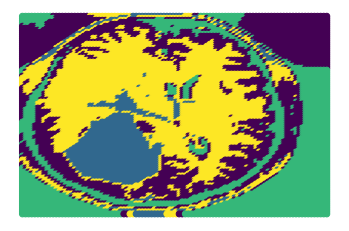

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors

# Create Plot

# cmap, norm = matplotlib.colors.from_levels_and_colors([0, 1, 2, 3, 4], ['lime', 'black', 'silver','rebeccapurple'])


X = to_draw['j'].tolist()
Y = to_draw['i'].tolist()
plt.scatter(X,Y,c=to_draw['clusters'].tolist(),marker='o')
plt.axis('off')
plt.gca().invert_yaxis()
plt.show()
#fig.savefig('Tomografia_paciente1_ordenado.png')


In [ ]:
# cluster_1 = data[0][(data[0]['clusters']==0)][['i','j','k']]
# cluster_1.to_csv('cluster1.xyz', sep=' ', header=None, index=False)


# cluster_2 = data[0][(data[0]['clusters']==1)][['i','j','k']]
# cluster_2.to_csv('cluster2.xyz', sep=' ', header=None, index=False)


# cluster_3 = data[0][(data[0]['clusters']==2)][['i','j','k']]
# cluster_3.to_csv('cluster3.xyz', sep=' ', header=None, index=False)


# cluster_4 = data[0][(data[0]['clusters']==3)][['i','j','k']]
# cluster_4.to_csv('cluster4.xyz', sep=' ', header=None, index=False)



# cluster_5 = data[0][(data[0]['clusters']==4)][['i','j','k']]
# cluster_5.to_csv('cluster5.xyz', sep=' ', header=None, index=False)


# cluster_6 = data[0][(data[0]['clusters']==5)][['i','j','k']]
# cluster_6.to_csv('cluster6.xyz', sep=' ', header=None, index=False)
